In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
np.random.seed(0)

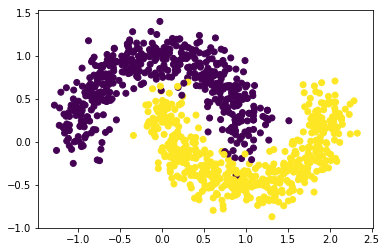

In [2]:
x, y = make_moons(n_samples=1000, noise=0.15)
x = np.column_stack((x, np.multiply(x[:,0], x[:,1])))
y = np.atleast_2d(y).T
x_train, x_test, y_train, y_test = train_test_split(x, y)
plt.scatter(x[:,0], x[:,1], c=y[:,0])

Number of samples, input units, number of output units:

In [3]:
assert x_train.shape[0] == y_train.shape[0]
x_train.shape[0], x_train.shape[1], y_train.shape[1]

(750, 3, 1)

\begin{align*}
h_\Theta(x) &= a^{(j + 1)} \\
a^{(j)} &= g(z^{(j)}) \\
z^{(j)} &= \Theta^{(j - 1)}a^{(j - 1)}
\end{align*}

Where $g$ is an activation function applied element-wise, $a^{(1)} = x$ (the overall network input), and $a^{(j)}_0 = 1$ for a bias unit for all layers $j$.

In [4]:
def sigmoid(z, derivative=False):
    if derivative:
        return z * (1 - z)
    return 1 / (1 + np.exp(-z))

## Non-vectorized implementation

In [5]:
x_train.shape, y_train.shape

((750, 3), (750, 1))

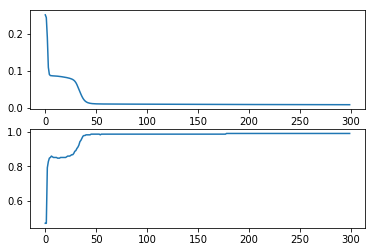

cost = 0.00922614421518 accuracy = 0.992


In [6]:
def a(weights, layer):
    z = weights.dot(layer)
    return sigmoid(z)


def construct_weights(layers):
    weights = []
    for l in range(1, len(layers)):
        # Add bias unit.
        incoming_units = layers[l - 1] + 1
        weights.append(np.random.uniform(-0.5, 0.5, (layers[l], incoming_units)))
    return tuple(weights)


def add_bias(x):
    return np.vstack((np.ones((1, 1)), x))


hidden_1_weights, hidden_2_weights, output_weights = construct_weights([3, 4, 4, 1])
costs = []
accuracies = []
max_learning_rate = 0.05
min_learning_rate = 0.00001
iterations = 300

for i in range(iterations):
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-i/iterations)
    cost = 0
    for sample, known in zip(x_train, y_train):
        x = add_bias(np.atleast_2d(sample).T)
        y = np.atleast_2d(known).T
        hidden_1_output = add_bias(a(hidden_1_weights, x))
        hidden_2_output = add_bias(a(hidden_2_weights, hidden_1_output))
        output_output = a(output_weights, hidden_2_output)
        # x and hidden layer activation outputs all include their bias units.

        # Compute the deltas for each activation and bias unit.
        output_delta = y - output_output
        hidden_2_delta = (output_weights.T).dot(output_delta) * sigmoid(hidden_2_output, derivative=True)
        # We don't connect this layer to the bias unit of the next.
        # For example:
        # - First hidden layer has 4 units and 1 bias unit for a total of 5 units.
        # - Second hidden layer has 3 units and 1 bias unit for a total of 4 units.
        # - The weight matrix between them is (3, 5) because the second hidden layer
        #   uses the first hidden layer's bias but the second hidden layer's bias is
        #   still always just 1.
        # - Thus we can splice off the second hidden layer's bias delta.
        hidden_1_delta = (hidden_2_weights.T).dot(hidden_2_delta[1:]) * sigmoid(hidden_1_output, derivative=True)
        
        output_pd = output_delta.dot(hidden_2_output.T)
        output_weights += learning_rate * output_pd

        hidden_2_pd = hidden_2_delta[1:].dot(hidden_1_output.T)
        hidden_2_weights += learning_rate * hidden_2_pd

        hidden_1_pd = hidden_1_delta[1:].dot(x.T)
        hidden_1_weights += learning_rate * hidden_1_pd
        
        cost += output_delta[0][0] ** 2

    costs.append(cost / len(x_train))
    correct = 0
    for sample, known in zip(x_test, y_test):
        x = add_bias(np.atleast_2d(sample).T)
        hidden_1_output = add_bias(a(hidden_1_weights, x))
        hidden_2_output = add_bias(a(hidden_2_weights, hidden_1_output))
        output_output = a(output_weights, hidden_2_output)
        prediction = 1 if output_output[0][0] >= 0.5 else 0
        if prediction == known[0]:
            correct += 1
    accuracies.append(correct / len(x_test))
    
plt.subplot(211)
plt.plot(costs)
plt.subplot(212)
plt.plot(accuracies)
plt.show()
print("cost =", costs[-1], "accuracy =", accuracies[-1])

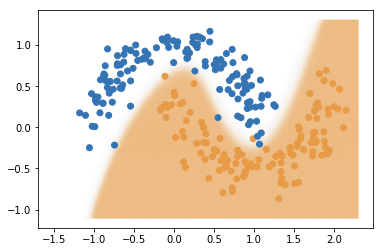

In [7]:
xbg, ybg, cbg, sbg = [], [], [], []
for x_ in np.linspace(-1.5, 2.3, num=400):
    for y_ in np.linspace(-1.1, 1.3, num=200):
        sample = np.atleast_2d(np.array([ x_, y_, x_ * y_ ])).T
        x = add_bias(sample)
        hidden_1_output = add_bias(a(hidden_1_weights, x))
        hidden_2_output = add_bias(a(hidden_2_weights, hidden_1_output))
        output_output = a(output_weights, hidden_2_output)
        xbg.append(x_)
        ybg.append(y_)
        cbg.append((237 / 255., 187 / 255., 129 / 255., output_output[0][0]))
        sbg.append(1)
        
        
def to_c(y):
    a = (232 / 255., 155 / 255., 71 / 255.)
    b = (52 / 255., 116 / 255., 181 / 255.)
    return [ a if y_ == 1 else b for y_ in y ]


plt.scatter(xbg, ybg, c=cbg, s=sbg, marker='.')
plt.scatter(x_test[:,0], x_test[:,1], c=to_c(y_test[:,0]))